In [1]:
import numpy as np 
from importlib import reload # for reloading modules after a script has been modified
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
sns.set()

# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import os
print(os.listdir("data"))


from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.manifold import TSNE

from sklearn.metrics import precision_score, recall_score

from scipy.stats import boxcox, t

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


['fr.openfoodfacts.org.products.csv']


In [45]:
import re

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, LinearSVR, SVR
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

import metric_learn

PUNCTUATION_REGEX = re.compile(r"""[:,;.&~"'|`_\\={}%()\[\]]+""")
DIGIT_REGEX = re.compile(r"[0-9]+")
MULTIPLE_SPACES_REGEX = re.compile(r" +")

def preprocess(text):
    text = PUNCTUATION_REGEX.sub(' ', text)
    text = DIGIT_REGEX.sub(' ', text)
    return MULTIPLE_SPACES_REGEX.sub(' ', text)

## Load data

In [3]:
df = pd.read_csv("data/fr.openfoodfacts.org.products.csv",
                       delimiter='\t',
                       encoding='utf-8',
                         nrows = 300000,
                      usecols=['product_name', 
                               'ingredients_text', 
                               'nutrition-score-fr_100g', 'carbon-footprint_100g', 
                             #  'energy_100g', 'fat_100g', 
                             #  'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                              'categories_tags','countries_tags','categories'
                              ],
                      converters={'categories_tags': lambda x: x.split(',') if x else np.NaN}
                      )
df.head(n=5)

,product_name,categories,categories_tags,countries_tags,ingredients_text,carbon-footprint_100g,nutrition-score-fr_100g
0,Vitória crackers,NaN,NaN,en:france,NaN,NaN,NaN
1,Cacao,NaN,NaN,en:france,NaN,NaN,NaN
2,Sauce Sweety chili 0%,NaN,NaN,en:france,NaN,NaN,NaN
3,Mini coco,NaN,NaN,en:france,NaN,NaN,NaN
4,Pistou d'ail des ours,NaN,NaN,en:france,NaN,NaN,NaN


In [4]:
df = df[pd.notnull(df['categories_tags'])]
df = df[pd.notnull(df['ingredients_text'])]
# df = df[pd.notnull(df['carbon-footprint_100g'])]


fr_df = df[df['countries_tags'] == 'en:france']

In [5]:
selected_categories = [
    "en:beverages",
    "en:sugary-snacks",
    "en:meals",
    "en:dairies",
    "en:meats",
    "en:desserts",
    "en:frozen-foods",
    "en:breakfasts",
    "en:cheeses",
    "en:biscuits",
    "en:groceries",
    "en:fats",
    "en:chocolates",
    "en:sauces",
]

selected_categories_set = set(selected_categories)

criterion = fr_df['categories_tags'].map(lambda x: bool(set(x).intersection(selected_categories_set)))
cat_df = fr_df[criterion]
cat_df['categories_tags_int'] = fr_df['categories_tags'].map(lambda categories: [selected_categories.index(x) for x in categories if x in selected_categories])
print(f"{len(fr_df)} elements in original dataframe, {len(cat_df)} after category filter")

21140 elements in original dataframe, 15615 after category filter


/home/lucas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
cat_df.head(5)

,product_name,categories,categories_tags,countries_tags,ingredients_text,carbon-footprint_100g,nutrition-score-fr_100g,categories_tags_int
260,Blanquette de Volaille et son Riz,"Plats préparés, Produits à la viande, Plats à ...","[en:meals, en:meat-based-products, en:meals-wi...",en:france,"Riz précuit 40,4 % (eau, riz, huile de colza, ...",NaN,0.0,[2]
276,Entremets Crème Brulée,"Produits laitiers, Desserts, Produits déshydra...","[en:dairies, en:desserts, en:dried-products, e...",en:france,"Sucre, poudre de _lait_, poudre au beurre (_la...",NaN,2.0,"[3, 5]"
307,Biscuits sablés fourrage au cacao,"Snacks sucrés, Biscuits et gâteaux, Biscuits, ...","[en:sugary-snacks, en:biscuits-and-cakes, en:b...",en:france,"Sucre, farine de _Blé_, graisse et huiles végé...",NaN,NaN,"[1, 9]"
309,A&w - Root Beer - 355ml,Boissons,"[en:beverages, en:non-alcoholic-beverages]",en:france,"Eau gazéifiée, sirop de mais riche en fructose...",NaN,16.0,[0]
313,Compote de Pomme,"Aliments et boissons à base de végétaux, Alime...","[en:plant-based-foods-and-beverages, en:plant-...",en:france,"Flocons de pommes 76 % (pomme, amidon de maïs,...",NaN,1.0,[5]


In [7]:
target = [np.array(c) for c in cat_df['categories_tags_int'].values] # several categories per sample
y = MultiLabelBinarizer().fit_transform(target) # one-hot of the targets
X = cat_df.ingredients_text.values

target = np.argmax(y,axis=1) # trivial reduce to 1 category per sample (loss of information)

idx_shuffle = np.random.permutation(X.shape[0])
X = X[idx_shuffle]
y = y[idx_shuffle,:]

idx_train = np.arange(1000)
idx_test = np.arange(1000,2000,1)
idx_both = np.concatenate([idx_train,idx_test],axis=0)
X_train = X[idx_train]
X_test = X[idx_test]
target_train = target[idx_train]
target_test = target[idx_test]
y_train = y[idx_train,:]
y_test = y[idx_test,:]


## Iterative HFS

In [71]:
decomposition_learner = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='unicode', min_df=5, preprocessor=preprocess)),
    ('tfidf', TfidfTransformer()),
    ('pca', TruncatedSVD(64))
])

In [72]:
X_proj = decomposition_learner.fit_transform(X)

In [73]:
import large_algos as lalg
from importlib import reload
reload(lalg)

pred,f = lalg.iterative_hfs(samples=X_proj[idx_both,:],
                            idx_lbl=idx_train,
                            labels_binary=y[idx_train,:], 
                              var=0.000001, eps=0, k=5, 
                          niter = 3, laplacian_regularization=0.1)

In [74]:
y[[idx_test,pred[idx_test]]].mean()

0.205

## Incremental centroids

In [212]:
from large_algos import incremental_k_centers

incremental_k_centers(labeled_samples=X_proj[:2000,:], labels)

SyntaxError: invalid syntax (<ipython-input-212-ac28494dfb51>, line 2)

## Baseline

In [203]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='unicode', min_df=5, preprocessor=preprocess)),
    ('tfidf', TfidfTransformer()),
    ('pca', TruncatedSVD(64)), # try with
    ('clf', OneVsRestClassifier(LinearSVC()))
])

classifier.fit(X[idx_train], y[idx_train,:])

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1),
        preprocessor=<function preprocess a..._class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None))])

In [207]:
y_pred = classifier.predict(X[idx_test])
print(classification_report(y[idx_test,:], y_pred, target_names=selected_categories))

                  precision    recall  f1-score   support

    en:beverages       0.90      0.64      0.74       174
en:sugary-snacks       0.87      0.84      0.86       219
        en:meals       0.84      0.65      0.73       127
      en:dairies       0.97      0.85      0.90       170
        en:meats       0.96      0.66      0.78       138
     en:desserts       0.71      0.36      0.48        69
 en:frozen-foods       0.00      0.00      0.00        34
   en:breakfasts       0.97      0.50      0.66        70
      en:cheeses       0.97      0.77      0.86        90
     en:biscuits       0.86      0.54      0.67        57
    en:groceries       0.88      0.12      0.21        58
         en:fats       0.00      0.00      0.00        31
   en:chocolates       0.71      0.34      0.46        44
       en:sauces       0.60      0.09      0.16        32

       micro avg       0.90      0.61      0.72      1313
       macro avg       0.73      0.45      0.54      1313
    weighted

/home/lucas/miniconda3/envs/basics/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/miniconda3/envs/basics/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/miniconda3/envs/basics/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/miniconda3/envs/basics/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in s

## PCA + Metric_learn + clf (LinearSVC / kNN)

In [12]:
decomposition_learner = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='unicode', min_df=5, preprocessor=preprocess)),
    ('tfidf', TfidfTransformer()),
    ('pca', TruncatedSVD(64)), # need this to transform above obtained sparse matrix
  #  ('metric_decomp', metric_learn.LFDA(k=8,embedding_type='weighted')) # does not impact the results much
    ('metric_decomp', metric_learn.LMNN(k=3,learn_rate=1e-7,min_iter=10,max_iter=10))
  #  ('metric_decomp', metric_learn.NCA(max_iter=10))
])

X_proj = decomposition_learner.fit_transform(np.concatenate([X_train,X_test],axis=0),
                                            np.concatenate([target_train,target_test],axis=0))

/home/lucas/anaconda3/lib/python3.7/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


In [31]:
classifier = Pipeline([
   # ('clf', OneVsRestClassifier(LinearSVC())),
    ('clf', KNeighborsClassifier(n_neighbors=5,weights='distance'))
])

classifier.fit(X_proj[idx_train],y_train)
pred = classifier.predict(X_proj[idx_test])

In [32]:
print(classification_report(y_test, pred, target_names=selected_categories))
print((y[idx_test,:] == pred).mean())
print((y[idx_test,:] == pred).mean(axis=0))
print(y[idx_test,:].mean(axis=0))

                  precision    recall  f1-score   support

    en:beverages       0.72      0.72      0.72       181
en:sugary-snacks       0.89      0.84      0.86       217
        en:meals       0.80      0.70      0.75       144
      en:dairies       0.96      0.74      0.84       169
        en:meats       0.90      0.81      0.86       135
     en:desserts       0.78      0.46      0.58        67
 en:frozen-foods       0.80      0.12      0.21        33
   en:breakfasts       0.89      0.52      0.66        63
      en:cheeses       0.91      0.81      0.86        93
     en:biscuits       0.67      0.65      0.66        57
    en:groceries       0.67      0.32      0.43        62
         en:fats       0.71      0.37      0.49        27
   en:chocolates       0.73      0.59      0.65        41
       en:sauces       1.00      0.12      0.22        33

     avg / total       0.84      0.67      0.73      1322

0.9562142857142857
[0.898 0.943 0.932 0.951 0.963 0.955 0.97  0.966 0

### Baseline : tfidf + LinearSVC

- baseline
```
       micro avg       0.90      0.68      0.77      1313
       macro avg       0.85      0.55      0.64      1313
    weighted avg       0.88      0.68      0.75      1313
     samples avg       0.72      0.68      0.69      1313
```
- tfidf + pca + LinearSVC
```
       micro avg       0.90      0.60      0.72      1313
       macro avg       0.79      0.45      0.53      1313
    weighted avg       0.86      0.60      0.68      1313
     samples avg       0.66      0.61      0.62      1313
```
- tfidf + pca + kNN
```
       micro avg       0.84      0.64      0.73      1360
       macro avg       0.83      0.55      0.63      1360
    weighted avg       0.84      0.64      0.72      1360
     samples avg       0.69      0.65      0.66      1360
```
### Metric learning : tfidf + TruncSVD(64) + metric + kNN
- LMNN(k=5,learn_rate=1e-5,min_iter=1,max_iter=3)
```
       micro avg       0.81      0.65      0.72      1360
       macro avg       0.71      0.54      0.60      1360
    weighted avg       0.78      0.65      0.70      1360
     samples avg       0.68      0.66      0.66      1360
```
- LFDA(k=8,embedding_type='weighted')
```
       micro avg       0.83      0.59      0.69      1360
       macro avg       0.84      0.50      0.59      1360
    weighted avg       0.84      0.59      0.67      1360
     samples avg       0.64      0.60      0.61      1360
```
- NCA(max_iter=10)
```
       micro avg       0.79      0.59      0.68      1360
       macro avg       0.69      0.48      0.55      1360
    weighted avg       0.76      0.59      0.65      1360
     samples avg       0.63      0.60      0.60      1360
```
### Metric learning : tfidf + TruncSVD(64) + metric + LinearSVC

- LMNN(k=5,learn_rate=1e-5,min_iter=1,max_iter=3)
```
       micro avg       0.88      0.67      0.76      1313
       macro avg       0.83      0.54      0.63      1313
    weighted avg       0.87      0.67      0.74      1313
     samples avg       0.69      0.67      0.67      1313
```
- LFDA(k=8,embedding_type='weighted')
```
       micro avg       0.92      0.62      0.74      1313
       macro avg       0.83      0.48      0.57      1313
    weighted avg       0.89      0.62      0.71      1313
     samples avg       0.68      0.63      0.64      1313
```
- NCA(max_iter=3)
```
       micro avg       0.86      0.68      0.76      1313
       macro avg       0.76      0.56      0.62      1313
    weighted avg       0.83      0.68      0.74      1313
     samples avg       0.70      0.68      0.68      1313
```
- NCA(max_iter=10)
```
       micro avg       0.73      0.70      0.72      1313
       macro avg       0.69      0.61      0.62      1313
    weighted avg       0.78      0.70      0.72      1313
     samples avg       0.66      0.71      0.66      1313
```
- NCA(max_iter=10) LinearSVC(maxiter=30000)
```
       micro avg       0.78      0.69      0.73      1313
       macro avg       0.67      0.58      0.62      1313
    weighted avg       0.77      0.69      0.73      1313
     samples avg       0.69      0.70      0.67      1313
```
- 
```
```
- 
```
```

# Benchmarking v2

In [91]:
# build dataset
target = [np.array(c) for c in cat_df['categories_tags_int'].values] # several categories per sample
y = MultiLabelBinarizer().fit_transform(target) # one-hot of the targets
X = cat_df.ingredients_text.values
target = np.argmax(y,axis=1) # trivial reduce to 1 category per sample (loss of information)

# build several pipelines
tfidf = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='unicode', min_df=10, preprocessor=preprocess)),
    ('tfidf', TfidfTransformer()),
])
def to_dense(x):
    return x.toarray()
proj = TruncatedSVD(64) # GaussianRandomProjection(64)
proj2 = FunctionTransformer(to_dense,validate=False)
reduces = [
    FunctionTransformer(validate=False),
    proj,
    Pipeline([('proj', proj), ('metric',metric_learn.LFDA(num_dims=64,k=8,embedding_type='weighted'))]),
    Pipeline([('proj', proj), ('metric',metric_learn.LMNN(k=3,learn_rate=1e-7,min_iter=5,max_iter=100,use_pca=False))]),
    Pipeline([('proj', proj), ('metric',metric_learn.NCA(num_dims=64,max_iter=100))])
]
baseline_clf = OneVsRestClassifier(LinearSVC())
metric_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
clfs = [
    baseline_clf,
    baseline_clf,
    metric_clf,
    metric_clf,
    metric_clf
]

# run experiments
n_exp = 30
n_clf = len(clfs)
assert n_clf == len(reduces)
recall_stats = np.zeros((n_exp,n_clf))
precision_stats = np.zeros((n_exp,n_clf))
for i_exp in tqdm(range(n_exp)):
    
    idx_shuffle = np.random.permutation(X.shape[0])
    X = X[idx_shuffle]
    y = y[idx_shuffle,:]
    target = target[idx_shuffle]

    idx_train = np.arange(1000)
    idx_test = np.arange(1000,2000,1)
    idx_both = np.concatenate([idx_train,idx_test],axis=0)
    target_train = target[idx_train]
    target_test = target[idx_test]
    X_train = X[idx_train]
    X_test = X[idx_test]
    y_train = y[idx_train,:]
    y_test = y[idx_test,:]
 
    X_tfidf = tfidf.fit_transform(np.concatenate([X_train,X_test],axis=0))
    
    for i_algo in range(n_clf):
        reduces[i_algo].fit(X_tfidf[idx_train,:],target_train)
        X_reduce = reduces[i_algo].transform(X_tfidf)
        clfs[i_algo].fit(X_reduce[idx_train],y_train)
        pred = clfs[i_algo].predict(X_reduce[idx_test])

        precision_stats[i_exp,i_algo] = precision_score(y_test,pred,average='weighted')
        recall_stats[i_exp,i_algo] = recall_score(y_test,pred,average='weighted')

/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)
/home/lucas/anaconda3/lib/python3.7/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')
/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/

/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)
/home/lucas/anaconda3/lib/python3.7/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')
/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/

/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)
/home/lucas/anaconda3/lib/python3.7/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')
/home/lucas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/

In [92]:
print(precision_stats.mean(axis=0))
print(recall_stats.mean(axis=0))
print(precision_stats)
print(recall_stats)

[0.86574848 0.84119514 0.82050499 0.82020304 0.79861089]
[0.6812321  0.60844256 0.67097463 0.65894102 0.67165781]
[[0.85500875 0.84788982 0.83504578 0.83498504 0.80200543]
 [0.860402   0.81560246 0.80732706 0.82350105 0.79579846]
 [0.84403728 0.82616725 0.79671133 0.79886964 0.76870327]
 [0.85450467 0.82568177 0.82371646 0.82075905 0.77875508]
 [0.83755412 0.85619919 0.81799621 0.83949943 0.81857293]
 [0.88067558 0.87299251 0.84896082 0.84327418 0.78713239]
 [0.88108349 0.83660971 0.80775679 0.83472947 0.81321292]
 [0.8531282  0.84516737 0.78325471 0.81257629 0.782016  ]
 [0.84456251 0.83121335 0.81138831 0.83361157 0.79795382]
 [0.86557627 0.80936445 0.8350917  0.81378727 0.78594584]
 [0.86155539 0.84953185 0.83009643 0.82455554 0.76525931]
 [0.8565868  0.84699973 0.8007462  0.82645018 0.80278116]
 [0.87478943 0.83224644 0.82240837 0.81608793 0.78829197]
 [0.86473422 0.80881914 0.84022852 0.81555541 0.81643825]
 [0.90807649 0.87002979 0.81504854 0.82028813 0.81786783]
 [0.85323319 0.8

### 1000-1000 pca - kNN(metric learn) - min_df=10

proj = TruncatedSVD(64) # GaussianRandomProjection(64)
reduces = [
    FunctionTransformer(validate=False),
    proj,
    Pipeline([('proj', proj), ('metric',metric_learn.LFDA(num_dims=64,k=8,embedding_type='weighted'))]),
    Pipeline([('proj', proj), ('metric',metric_learn.LMNN(k=3,learn_rate=1e-7,min_iter=5,max_iter=100,use_pca=False))]),
    Pipeline([('proj', proj), ('metric',metric_learn.NCA(num_dims=64,max_iter=100))])
]
baseline_clf = OneVsRestClassifier(LinearSVC())
metric_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
clfs = [
    baseline_clf,
    baseline_clf,
    metric_clf,
    metric_clf,
    metric_clf
]

[0.86574848 0.84119514 0.82050499 0.82020304 0.79861089]

[0.6812321  0.60844256 0.67097463 0.65894102 0.67165781]

[[0.85500875 0.84788982 0.83504578 0.83498504 0.80200543]
 [0.860402   0.81560246 0.80732706 0.82350105 0.79579846]
 [0.84403728 0.82616725 0.79671133 0.79886964 0.76870327]
 [0.85450467 0.82568177 0.82371646 0.82075905 0.77875508]
 [0.83755412 0.85619919 0.81799621 0.83949943 0.81857293]
 [0.88067558 0.87299251 0.84896082 0.84327418 0.78713239]
 [0.88108349 0.83660971 0.80775679 0.83472947 0.81321292]
 [0.8531282  0.84516737 0.78325471 0.81257629 0.782016  ]
 [0.84456251 0.83121335 0.81138831 0.83361157 0.79795382]
 [0.86557627 0.80936445 0.8350917  0.81378727 0.78594584]
 [0.86155539 0.84953185 0.83009643 0.82455554 0.76525931]
 [0.8565868  0.84699973 0.8007462  0.82645018 0.80278116]
 [0.87478943 0.83224644 0.82240837 0.81608793 0.78829197]
 [0.86473422 0.80881914 0.84022852 0.81555541 0.81643825]
 [0.90807649 0.87002979 0.81504854 0.82028813 0.81786783]
 [0.85323319 0.85569997 0.79959373 0.78047825 0.76660429]
 [0.88011285 0.8645096  0.83982767 0.83971774 0.81727293]
 [0.87879356 0.82176613 0.8553916  0.83351294 0.79732816]
 [0.83862748 0.80803083 0.79040728 0.77550077 0.76676183]
 [0.859671   0.83199189 0.82589188 0.81265455 0.82820491]
 [0.8933309  0.88508636 0.8725077  0.8274153  0.79213234]
 [0.87780561 0.85007071 0.82749653 0.83223451 0.80730327]
 [0.86719424 0.8248033  0.79522303 0.83231193 0.76893808]
 [0.86855067 0.84153706 0.83487088 0.82488615 0.81883384]
 [0.88227509 0.85779275 0.84246944 0.83674294 0.8061955 ]
 [0.87204687 0.85347229 0.8151394  0.81073483 0.82778212]
 [0.87757999 0.81729838 0.82074656 0.81012068 0.79063174]
 [0.84769911 0.85788057 0.78825699 0.79364722 0.80146933]
 [0.86143297 0.84584209 0.81232137 0.82172009 0.80222714]
 [0.87182572 0.84555736 0.81922841 0.81588302 0.84590648]]
 
[[0.69329314 0.6360211  0.66691786 0.67822155 0.69253956]
 [0.65584906 0.58716981 0.64226415 0.65056604 0.65660377]
 [0.68409091 0.59166667 0.67954545 0.65909091 0.66515152]
 [0.6823351  0.60121304 0.67551175 0.6777862  0.6702047 ]
 [0.67000771 0.61912105 0.64533539 0.65921357 0.64764842]
 [0.68649886 0.62471396 0.6849733  0.65751335 0.66514111]
 [0.6769468  0.60447186 0.67000771 0.6692367  0.67617579]
 [0.66640986 0.596302   0.67026194 0.61171032 0.65485362]
 [0.67816954 0.60990248 0.67366842 0.66166542 0.66616654]
 [0.67631379 0.58644326 0.64204113 0.64737243 0.66031988]
 [0.70077519 0.61860465 0.67984496 0.68837209 0.69534884]
 [0.65962264 0.59698113 0.64150943 0.63471698 0.65886792]
 [0.70077519 0.63410853 0.70310078 0.68449612 0.67131783]
 [0.67969349 0.58697318 0.64214559 0.63601533 0.65363985]
 [0.67868098 0.59279141 0.6756135  0.6595092  0.66027607]
 [0.67386276 0.5998458  0.66615266 0.64533539 0.68388589]
 [0.69341408 0.5987888  0.69644209 0.67070401 0.66010598]
 [0.70789074 0.62139605 0.68437026 0.69650986 0.68361153]
 [0.66818527 0.60971906 0.67653759 0.64160972 0.68109339]
 [0.66332046 0.58455598 0.63629344 0.63706564 0.64787645]
 [0.68802441 0.60945843 0.66209001 0.66285278 0.65980168]
 [0.67228178 0.59800919 0.68070444 0.65237366 0.67457887]
 [0.67179093 0.60261337 0.688701   0.63797079 0.67563413]
 [0.68015267 0.62137405 0.66793893 0.6610687  0.66564885]
 [0.67717718 0.6036036  0.66141141 0.66666667 0.70195195]
 [0.69629057 0.62982998 0.71174652 0.66846986 0.68315301]
 [0.68153846 0.59923077 0.66692308 0.66       0.67      ]
 [0.67978395 0.63040123 0.67901235 0.66049383 0.67592593]
 [0.69492808 0.62906889 0.666919   0.65253596 0.70704012]
 [0.69885932 0.62889734 0.69125475 0.67908745 0.6851711 ]]

### 1000-1000 pca - kNN(mahalanobis) - min_df=10

proj = TruncatedSVD(64)
reduces = [
    FunctionTransformer(validate=False),
    proj,
    proj
]
baseline_clf = OneVsRestClassifier(LinearSVC())
metric_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
mahal_clf = KNeighborsClassifier(n_neighbors=5,weights='distance',metric='mahalanobis',
                                 metric_params={'V'=EmpiricalCovariance().covariance_}) # en gros
clfs = [
    baseline_clf,
    baseline_clf,
    mahal_clf
]

[0.87199389 0.84370394 0.81228873]
[0.68480356 0.6416532  0.61276954]
[[0.85259618 0.81520118 0.8041943 ]
 [0.87797382 0.86887106 0.8255814 ]
 [0.83661504 0.80308129 0.80582481]
 [0.85031857 0.84717084 0.81533743]
 [0.89502992 0.82367964 0.795891  ]
 [0.91025825 0.86617837 0.8454361 ]
 [0.90546089 0.89611035 0.84160868]
 [0.85685195 0.82127957 0.77646052]
 [0.87321899 0.84051446 0.79268863]
 [0.86161532 0.85495261 0.81986446]]
[[0.67800454 0.6318972  0.61073318]
 [0.69908116 0.64165391 0.59724349]
 [0.67215569 0.63248503 0.60853293]
 [0.6766055  0.63685015 0.62920489]
 [0.67884323 0.63774734 0.5913242 ]
 [0.7000771  0.65458751 0.62528913]
 [0.71341926 0.6747536  0.63305534]
 [0.67534456 0.6179173  0.60643185]
 [0.67511521 0.63978495 0.61290323]
 [0.67938931 0.64885496 0.6129771 ]]

# Plot statistics of benchmark

In [37]:
a = "[[0.90524956 0.83213418 0.82006228 0.68349922] [0.87063306 0.86611653 0.83494405 0.73172916] [0.87769694 0.87162715 0.83844925 0.70373871] [0.89912888 0.84884026 0.82259382 0.75061528] [0.88997331 0.8183048 0.84362678 0.55371549] [0.87667362 0.83807362 0.81765719 0.56331283] [0.85276781 0.86456269 0.84339287 0.71012747] [0.87004688 0.82870832 0.84771631 0.63951567] [0.85738362 0.81963986 0.80687764 0.73403679] [0.85315323 0.8416152 0.81464178 0.75363327]]"
a.replace(' ',',')

'[[0.90524956,0.83213418,0.82006228,0.68349922],[0.87063306,0.86611653,0.83494405,0.73172916],[0.87769694,0.87162715,0.83844925,0.70373871],[0.89912888,0.84884026,0.82259382,0.75061528],[0.88997331,0.8183048,0.84362678,0.55371549],[0.87667362,0.83807362,0.81765719,0.56331283],[0.85276781,0.86456269,0.84339287,0.71012747],[0.87004688,0.82870832,0.84771631,0.63951567],[0.85738362,0.81963986,0.80687764,0.73403679],[0.85315323,0.8416152,0.81464178,0.75363327]]'

In [96]:
b1_acc = "[[0.85500875 0.84788982 0.83504578 0.83498504 0.80200543] [0.860402 0.81560246 0.80732706 0.82350105 0.79579846] [0.84403728 0.82616725 0.79671133 0.79886964 0.76870327] [0.85450467 0.82568177 0.82371646 0.82075905 0.77875508] [0.83755412 0.85619919 0.81799621 0.83949943 0.81857293] [0.88067558 0.87299251 0.84896082 0.84327418 0.78713239] [0.88108349 0.83660971 0.80775679 0.83472947 0.81321292] [0.8531282 0.84516737 0.78325471 0.81257629 0.782016 ] [0.84456251 0.83121335 0.81138831 0.83361157 0.79795382] [0.86557627 0.80936445 0.8350917 0.81378727 0.78594584] [0.86155539 0.84953185 0.83009643 0.82455554 0.76525931] [0.8565868 0.84699973 0.8007462 0.82645018 0.80278116] [0.87478943 0.83224644 0.82240837 0.81608793 0.78829197] [0.86473422 0.80881914 0.84022852 0.81555541 0.81643825] [0.90807649 0.87002979 0.81504854 0.82028813 0.81786783] [0.85323319 0.85569997 0.79959373 0.78047825 0.76660429] [0.88011285 0.8645096 0.83982767 0.83971774 0.81727293] [0.87879356 0.82176613 0.8553916 0.83351294 0.79732816] [0.83862748 0.80803083 0.79040728 0.77550077 0.76676183] [0.859671 0.83199189 0.82589188 0.81265455 0.82820491] [0.8933309 0.88508636 0.8725077 0.8274153 0.79213234] [0.87780561 0.85007071 0.82749653 0.83223451 0.80730327] [0.86719424 0.8248033 0.79522303 0.83231193 0.76893808] [0.86855067 0.84153706 0.83487088 0.82488615 0.81883384] [0.88227509 0.85779275 0.84246944 0.83674294 0.8061955 ] [0.87204687 0.85347229 0.8151394 0.81073483 0.82778212] [0.87757999 0.81729838 0.82074656 0.81012068 0.79063174] [0.84769911 0.85788057 0.78825699 0.79364722 0.80146933] [0.86143297 0.84584209 0.81232137 0.82172009 0.80222714] [0.87182572 0.84555736 0.81922841 0.81588302 0.84590648]]"
b1_rec = "[[0.69329314 0.6360211 0.66691786 0.67822155 0.69253956] [0.65584906 0.58716981 0.64226415 0.65056604 0.65660377] [0.68409091 0.59166667 0.67954545 0.65909091 0.66515152] [0.6823351 0.60121304 0.67551175 0.6777862 0.6702047 ] [0.67000771 0.61912105 0.64533539 0.65921357 0.64764842] [0.68649886 0.62471396 0.6849733 0.65751335 0.66514111] [0.6769468 0.60447186 0.67000771 0.6692367 0.67617579] [0.66640986 0.596302 0.67026194 0.61171032 0.65485362] [0.67816954 0.60990248 0.67366842 0.66166542 0.66616654] [0.67631379 0.58644326 0.64204113 0.64737243 0.66031988] [0.70077519 0.61860465 0.67984496 0.68837209 0.69534884] [0.65962264 0.59698113 0.64150943 0.63471698 0.65886792] [0.70077519 0.63410853 0.70310078 0.68449612 0.67131783] [0.67969349 0.58697318 0.64214559 0.63601533 0.65363985] [0.67868098 0.59279141 0.6756135 0.6595092 0.66027607] [0.67386276 0.5998458 0.66615266 0.64533539 0.68388589] [0.69341408 0.5987888 0.69644209 0.67070401 0.66010598] [0.70789074 0.62139605 0.68437026 0.69650986 0.68361153] [0.66818527 0.60971906 0.67653759 0.64160972 0.68109339] [0.66332046 0.58455598 0.63629344 0.63706564 0.64787645] [0.68802441 0.60945843 0.66209001 0.66285278 0.65980168] [0.67228178 0.59800919 0.68070444 0.65237366 0.67457887] [0.67179093 0.60261337 0.688701 0.63797079 0.67563413] [0.68015267 0.62137405 0.66793893 0.6610687 0.66564885] [0.67717718 0.6036036 0.66141141 0.66666667 0.70195195] [0.69629057 0.62982998 0.71174652 0.66846986 0.68315301] [0.68153846 0.59923077 0.66692308 0.66 0.67 ] [0.67978395 0.63040123 0.67901235 0.66049383 0.67592593] [0.69492808 0.62906889 0.666919 0.65253596 0.70704012] [0.69885932 0.62889734 0.69125475 0.67908745 0.6851711 ]]"
b2_acc = "[[0.85259618 0.81520118 0.8041943 ] [0.87797382 0.86887106 0.8255814 ] [0.83661504 0.80308129 0.80582481] [0.85031857 0.84717084 0.81533743] [0.89502992 0.82367964 0.795891 ] [0.91025825 0.86617837 0.8454361 ] [0.90546089 0.89611035 0.84160868] [0.85685195 0.82127957 0.77646052] [0.87321899 0.84051446 0.79268863] [0.86161532 0.85495261 0.81986446]]"
b2_rec = "[[0.67800454 0.6318972 0.61073318] [0.69908116 0.64165391 0.59724349] [0.67215569 0.63248503 0.60853293] [0.6766055 0.63685015 0.62920489] [0.67884323 0.63774734 0.5913242 ] [0.7000771 0.65458751 0.62528913] [0.71341926 0.6747536 0.63305534] [0.67534456 0.6179173 0.60643185] [0.67511521 0.63978495 0.61290323] [0.67938931 0.64885496 0.6129771 ]]"
def convert(b):
    b = b.replace(' ',',')
    return np.array(eval(b))
b1_acc = convert(b1_acc)
b1_rec = convert(b1_rec)
b2_acc = convert(b2_acc)
b2_rec = convert(b2_rec)

experiments = ['baseline', 'baseline +PCA', 'LFDA', 'LMNN', 'NCA', 'Mahalanobis']
b_acc_mean = np.hstack([b1_acc.mean(axis=0),b2_acc[:,[2]].mean(axis=0)])
b_acc_std = np.hstack([b1_acc.std(axis=0),b2_acc[:,[2]].std(axis=0)])
b_rec_mean = np.hstack([b1_rec.mean(axis=0),b2_rec[:,[2]].mean(axis=0)])
b_rec_std = np.hstack([b1_rec.std(axis=0),b2_rec[:,[2]].std(axis=0)])

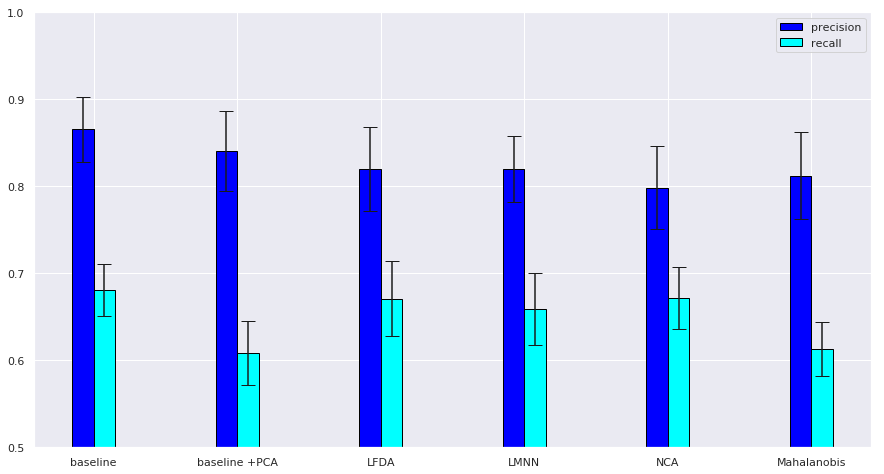

In [99]:
confidence = 0.75

n_alg = bench_acc.shape[1]
barWidth = 0.3
r1 = 2*np.arange(n_alg)
r2 = [x + barWidth for x in r1]

conf_ranges_acc = np.array(t.interval(confidence,[30,30,30,30,30,10],loc=b_acc_mean,scale=b_acc_std))
conf_ranges_rec = np.array(t.interval(confidence,[30,30,30,30,30,10],loc=b_rec_mean,scale=b_rec_std))
conf_ranges_acc = conf_ranges_acc[1,:] - conf_ranges_acc[0,:]
conf_ranges_rec = conf_ranges_rec[1,:] - conf_ranges_rec[0,:]

plt.figure(figsize=(15,8))
# Create blue bars
plt.bar(r1, b_acc_mean, width=barWidth, color='blue', edgecolor='black',
        yerr=conf_ranges_acc, capsize=7, label='precision')
 
# Create cyan bars
plt.bar(r2, b_rec_mean, width=barWidth, color='cyan', edgecolor='black',
        yerr=conf_ranges_rec, capsize=7, label='recall')

# general layout
plt.xticks([r + barWidth/2 for r in r1], experiments)
plt.ylabel('')
plt.legend()
plt.ylim([0.5,1])
 
# Show graphic
plt.show()

# Create and visualize projections 

In [28]:
# build dataset
target = [np.array(c) for c in cat_df['categories_tags_int'].values] # several categories per sample
y = MultiLabelBinarizer().fit_transform(target) # one-hot of the targets
X = cat_df.ingredients_text.values
target = np.argmax(y,axis=1) # trivial reduce to 1 category per sample (loss of information)

# select samples
idx_shuffle = np.random.permutation(X.shape[0])
X = X[idx_shuffle]
y = y[idx_shuffle,:]
target = target[idx_shuffle]
idx_train = np.arange(5000)

# build 1 pipeline proj+clf
proj_tfidf = Pipeline([
    ('vectorizer', CountVectorizer(strip_accents='unicode', min_df=10, preprocessor=preprocess)),
    ('tfidf', TfidfTransformer())
])
proj_vanilla = Pipeline([
    ('proj_tfidf',proj_tfidf),
    ('pca', TruncatedSVD(64))
])
proj = Pipeline([
    ('proj_vanilla', proj_vanilla),
    ('metric',metric_learn.LFDA(num_dims=64,k=8,embedding_type='weighted'))
])

# fit
proj.fit(X[idx_train],target[idx_train])
X_tfidf = proj_tfidf.transform(X)
X_proj_vanilla = proj_vanilla.transform(X)
X_proj = proj.transform(X)

/home/lucas/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


In [107]:
X_2_vanilla = TSNE(2).fit_transform(X_proj_vanilla)
X_2 = TSNE(2).fit_transform(X_proj)

In [147]:
n_classes = len(np.unique(target))
dispersion = np.zeros((2,n_classes))
for i,cl in enumerate(np.unique(target)):
    idx_class_i = np.where(target == cl)[0]
    mean = X_proj_vanilla[idx_class_i,:].mean(axis=0)
    dispersion[0,i] = np.sum((X_proj_vanilla - mean.T)**2,axis=1).mean(axis=0)
    mean = X_proj[idx_class_i,:].mean(axis=0)
    dispersion[1,i] = np.sum((X_proj - mean.T)**2,axis=1).mean(axis=0)
print(dispersion)
print(dispersion.mean(axis=1))

[[0.42147303 0.44466825 0.43263476 0.46340428 0.46005949 0.45370856
  0.40114144 0.43711109 0.41589032 0.43023694]
 [0.3472886  0.38647028 0.39731744 0.39692869 0.4015338  0.36669924
  0.32316215 0.45005321 0.35620747 0.33506439]]
[0.43603282 0.37607253]


([], <a list of 0 Text yticklabel objects>)

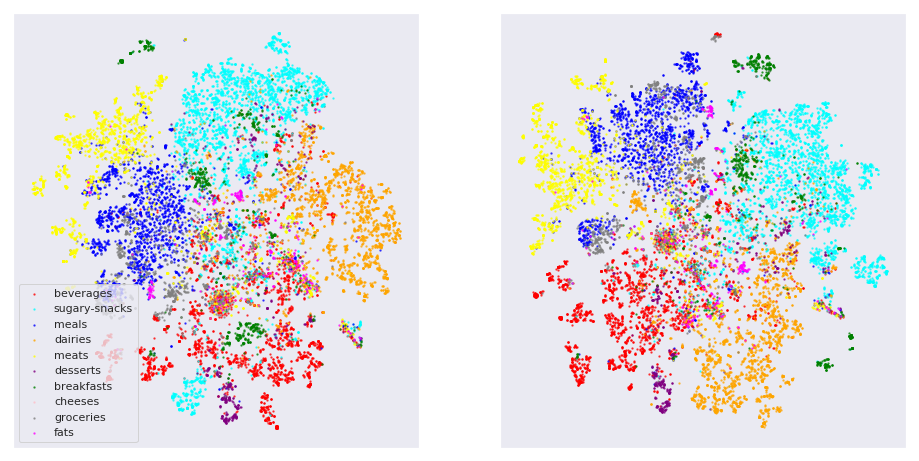

In [133]:
n_classes = len(np.unique(target))
classes = [0,1,2,3,4,5,7,8,10,11]

colors = ['red','cyan','blue','orange','yellow','purple','6','green','pink','9','gray','magenta','12','13']

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
for i in classes:
    idx_class_i = np.where(target == i)[0]
    plt.scatter(X_2_vanilla[idx_class_i,0],
                X_2_vanilla[idx_class_i,1],
                color=colors[i],label=selected_categories[i][3:],alpha=0.6,s=2)
plt.legend()
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
for i in classes:
    idx_class_i = np.where(target == i)[0]
    plt.scatter(X_2[idx_class_i,0],
                X_2[idx_class_i,1],
                color=colors[i],label=selected_categories[i][3:],alpha=0.6,s=2)
plt.xticks([])
plt.yticks([])


# Load for carbon footprint

In [16]:
df_co2 = pd.read_csv("data/fr.openfoodfacts.org.products.csv",
                       delimiter='\t',
                       encoding='utf-8',
                     #    nrows = 300000,
                      usecols=['product_name', 
                               'ingredients_text', 
                               'nutrition-score-fr_100g', 'carbon-footprint_100g', 
                             #  'energy_100g', 'fat_100g', 
                             #  'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                              'categories_tags','countries_tags','categories'
                              ],
                      )
df_co2 = df_co2[pd.notnull(df_co2['ingredients_text'])]
df_co2 = df_co2[pd.notnull(df_co2['carbon-footprint_100g'])]
df_co2 = df_co2[np.array(df_co2['carbon-footprint_100g']) != 0]
print(len(df_co2))
df_co2.head(n=5)

245


,product_name,categories,categories_tags,countries_tags,ingredients_text,carbon-footprint_100g,nutrition-score-fr_100g
187784,châtaignes pelées et rôties cesares,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba...",en:canada,châtaignes naturelles,300.00,0.0
216958,Terrine de Chevreuil,"Produits à la viande, Terrines, Terrines de ch...","en:meat-based-products,en:terrine,fr:terrines-...",en:france,"Viande, gras et foie de Porc 25%, viande de Ch...",0.05,21.0
216966,TERRINE AUX CHÂTAIGNES,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba...",en:france,"Viande, Gras, Foie de Porc 30% (origine France...",0.05,21.0
227872,Emotionali Multi Fruit Lollies,NaN,NaN,en:france,RI (reference intake) = Referentie-inname van ...,135.00,NaN
236912,Jogourt Nature ferme,Yaourt,"en:dairies,en:fermented-foods,en:fermented-mil...",en:switzerland,"yogourt (lait, lait écrémé en poudre)",57.80,1.0
236913,Yogourt Ananas,"Produits laitiers, Produits fermentés, Produit...","en:dairies,en:fermented-foods,en:fermented-mil...",en:switzerland,"yogourt (lait, protéines du lait), sucre 8.4%,...",48.20,3.0
236918,"Migros, M Classic","Produits laitiers, Produits fermentés, Produit...","en:dairies,en:fermented-foods,en:fermented-mil...",en:switzerland,"Ingrédients: yogourt (_lait_,_ protéines du la...",199.70,4.0
236921,Yogurt Mandarine,"Produits laitiers, Produits fermentés, Produit...","en:dairies,en:fermented-foods,en:fermented-mil...",en:switzerland,"yogourt (_lait_, _protéines du lait_), sucre 9...",196.50,4.0
236924,Yogourt Rhubarbe/Vanille,"Produits laitiers, Produits fermentés, Produit...","en:dairies,en:fermented-foods,en:fermented-mil...","en:france,en:germany,en:switzerland","yogourt (_lait_ écrémé, crème, protéines du la...",193.40,4.0
237777,Choco Drink,Produits laitiers,en:dairies,en:switzerland,"Lait écrémé 98%, chocolat 1.5%, épaississants:...",59.30,-1.0


# Predict carbon footprint

In [67]:
from sklearn.model_selection import LeaveOneOut

# build dataset
target = np.array(df_co2['carbon-footprint_100g'])
t_mean = target.mean()
t_std = target.std()
target = (target - t_mean)/t_std
X = df_co2.ingredients_text.values

X_tfidf = proj_tfidf.transform(X)
X_proj_vanilla = proj_vanilla.transform(X) # count + tf-idf + pca
X_proj = proj.transform(X) # above + LFDA

# build several pipelines
projs = ['1tfidf+LinearSVR','2tfidf+PCA+LinearSVR','3tfidf+PCA+SVR','4tfidf+PCA+LFDA+SVR']
clfs = [LinearSVR(tol=1e-4,epsilon=0,C=1),LinearSVR(tol=1e-4,epsilon=0,C=1),SVR(tol=1e-4,C=80),SVR(tol=1e-4,C=80)]

# leave one out experiments
loo = LeaveOneOut()
L1_error_stats = list(list() for _ in projs)
preds = list(list() for _ in projs)
for idx_train, idx_test in loo.split(X):
    target_train = target[idx_train]
    target_test = target[idx_test]
    
    for i_proj_method,proj_method in enumerate(projs):
        if proj_method[0] == '1':
            X_train = X_tfidf[idx_train]
            X_test = X_tfidf[idx_test]
        elif proj_method[0] == '2' or proj_method[0] == '3':
            X_train = X_proj_vanilla[idx_train]
            X_test = X_proj_vanilla[idx_test]
        elif proj_method[0] == '4':
            X_train = X_proj[idx_train]
            X_test = X_proj[idx_test]
        else:
            assert False
    
        clf = clfs[i_proj_method]
        
        clf.fit(X_train,target_train)

        pred = clf.predict(X_test)
        preds[i_proj_method].append(pred[0])

        L1_error_stats[i_proj_method].append(np.abs(pred-target_test)[0])

preds = np.array(preds)
L1_error_stats = np.array(L1_error_stats)
print(L1_error_stats.mean(axis=1)*t_std)

[171.75191128 212.71646943 207.89538625 209.29214511]


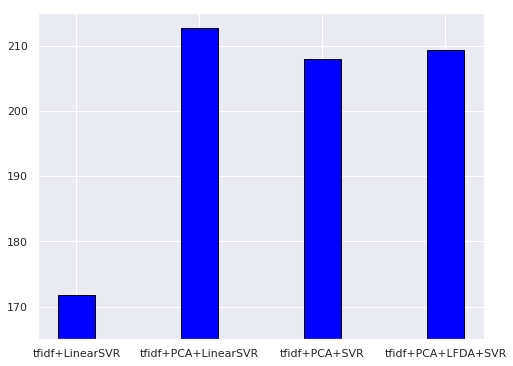

In [71]:
plt.figure(figsize=(8,6))

r1 = np.arange(len(clfs))

# Create blue bars
plt.bar(r1, L1_error_stats.mean(axis=1)*t_std, width=0.3, color='blue', edgecolor='black')
 
# general layout
plt.xticks([r for r in r1], [_[1:] for _ in projs])
plt.ylabel('')
plt.ylim([165,215])
 
# Show graphic
plt.show()

Text(0,0.5,'Occurences')

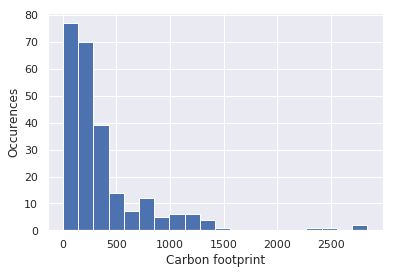

In [44]:
plt.hist(target*t_std+t_mean,bins=20)
plt.xlabel('Carbon footprint')
plt.ylabel('Occurences')

In [26]:
(target*t_std+t_mean).mean()

364.2098151020408

TODO

carbon footprint :
- chercher un algo regression qui puisse utiliser entrées sparse
- comparer avec PCA + LMNN + (log ?) regression


NOTES

PCA appears to be a bad decomposer (LinearSVC loses drastic performances) yet it is an simple algorithm to extract information from large scale sparse matrices for algorithms that cannot work on such large matrices

We try and find the best decomposer based on the categorization problem to then use it for the carbon footprint regression problem.

We find that PCA+LMNN is a good decomposer, giving results very close to LinearSVC for categorization.